# Introduction

[Dataset](https://archive-beta.ics.uci.edu/dataset/296/diabetes+130+us+hospitals+for+years+1999+2008) UCI "Diabetes 130-US hospitals for years 1999-2008" [1]

The purpose of this project is to develop a prediction model for <30-day readmissions of diabetic patients. These readmissions can significantly impact Medicare billing, potentially leading to financial penalties for hospitals with high readmission rates. By identifying the key features used by the model to make its classifications, hospitals can develop informed treatment plans to reduce the likelihood of readmissions. Additionally, the model can be used in real-time to predict the probability of a patient"s readmission, providing healthcare professionals with valuable insights for optimizing patient care.


[1] Clore,John, Cios,Krzysztof, DeShazo,Jon & Strack,Beata. (2014). Diabetes 130-US hospitals for years 1999-2008. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.

In [1]:
import pandas as pd  # Importing pandas library and renaming it to pd for convenience
import pickle  # Importing the pickle library for reading in saved models later
import numpy as np  # Importing numpy library and renaming it to np for convenience
import matplotlib.pyplot as plt  # Importing matplotlib library and renaming it to plt for convenience
import time  # Importing the time library for tracking the duration of certain operations

pd.options.mode.chained_assignment = None  # Setting pandas chained_assignment option to None to suppress warning messages

seed = 42  # Setting a seed for reproducibility of randomization functions

start_time = time.time()  # Setting a starting time for tracking the duration of certain operations


In [2]:
plt.style.use("ggplot")  # Setting the default style for Matplotlib to "ggplot"

my_style = {  # Defining a custom style dictionary with new colors and formatting options
    "axes.prop_cycle": plt.cycler(color=["#015bd3", "#fd5305", "#ffd2ea"]),
    "text.color": "#191919",
    "text.color": "#191919",
    "xtick.color": "#191919",
    "ytick.color": "#191919",
    "axes.labelcolor": "#191919",
    "legend.edgecolor": "white",
    "axes.facecolor": "#ebecf0",
}

# Setting the custom style for Matplotlib
plt.style.use(my_style)  

# Data Processing
First, we will load in the data and look at some of its characterisitics.

In [3]:
# Reading in the "diabetic_data.csv" file and eplacing all "?" values in the DataFrame with NaN (missing) values
df_raw = pd.read_csv("dataset_diabetes/diabetic_data.csv", na_values=["NaN", "?", np.nan])

# Displaying the first few rows of the DataFrame using the head() method
df_raw.head()

/var/folders/cp/k4r1_sbx687dqn2rzgz3t7n40000gn/T/ipykernel_81362/3222780403.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("dataset_diabetes/diabetic_data.csv", na_values=["NaN", "?", np.nan])


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
df_raw.info() # Display dataframe info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

## Denoise
I have decided to denoise the dataset by removing any unnecessary or irrelevant information that may be present. There are several reasons for doing so. Firstly, I believe that denoising the dataset will improve the quality of the data and reduce any noise or bias that may be present, ultimately leading to more accurate and reliable results. Additionally, it will help to simplify the analysis and reduce the complexity of the data, making it easier to work with and understand. By focusing on the most relevant features of the dataset, I hope to identify important patterns and insights that will help me to achieve my project objectives. Overall, I believe that denoising the dataset is an important step in my data science project to improve the quality of the data, simplify the analysis, and increase the accuracy and reliability of the results.

### Remove columns composed of >30% nan values

Before dropping nan values, I will drop the columns with a signifficant number of nan values.  This will increase the total number of data points after dropping.

In [5]:
df = df_raw.copy()  # Creating a copy of the original DataFrame to avoid modifying it directly.

# Creating a list of column names to drop from the DataFrame based on a threshold of missing values.
col_to_drop = list(df_raw.columns[df_raw.isna().sum() > len(df_raw) * 0.3])
col_to_drop.remove("medical_specialty")  # Removing the "medical_specialty" column from the list, as it was deemed important.

list(col_to_drop)  # Displaying the list of column names to be dropped.

['weight', 'payer_code']

### Remove Unused Medications And Irrelevant Columns
Now I will drop the columns that have been deemed unnecessary (col_to_drop and unused_meds), as well as the "encounter_id" and "patient_nbr" columns which are patient identifiers and not relevant for the analysis.

In [6]:
unused_meds = ["examide", "citoglipton", "metformin-rosiglitazone"]  # Creating a list of medication columns to be dropped as they only contain None values.

df = df.drop(columns=col_to_drop + unused_meds + ["encounter_id", "patient_nbr"]).dropna()
# Finally, dropping rows with missing values using the dropna() method.

df.shape  # Displaying the new dimensions (shape) of the DataFrame after the columns and rows have been dropped. 


(49735, 43)

### Remove Infrequent Medications
In order to enhance the denoising process of the dataset, I have decided to remove medications that are rarely used. To achieve this, I have filtered out the medications that do not contain all four possible values of administration. This approach aligns with my research on the most common medications used to treat diabetes. By removing the rarely used medications, I can reduce any noise or bias that may be present in the dataset, which can ultimately lead to more accurate and reliable results.

In [7]:
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-pioglitazone']

In [8]:
# Subset the dataframe to just the medication columns
drugs = df[drug_cols].copy()

# Identify the columns that do not have exactly 4 unique values
drugs_to_drop = drugs.columns[drugs.nunique() != 4]

# Drop the columns from the original dataframe
df.drop(columns=drugs_to_drop, inplace=True)


### Remove patients who died or were transferred to hospice

These patients will not be readmitted and a model is not needed to determine that. Their inclusion would likely confuse the model.

In [9]:
df = df[~(df.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21, 26]))]

### Group unknown ID values to "other"
This is done to reduce the dimensionality of the dataset while also creating potentially useful features.

In [10]:
mappings_raw = pd.read_csv("dataset_diabetes/IDs_mapping.csv", header=None)

admin_type_map = mappings_raw.iloc[0:9, :]
discharge_type_map = mappings_raw.iloc[10:41, :]
admin_source_map = mappings_raw.iloc[42:, :]

dfs = [admin_type_map, discharge_type_map, admin_source_map]

for _df in dfs:
    _df.columns = _df.iloc[0]  # Renaming the columns with the first row values
    _df.drop(_df.index[0], inplace=True)  # Dropping the first row as it is now redundant
    _df.reset_index(drop=True, inplace=True)  # Resetting the index to start at 0 and drop the old index
    _df.set_index(_df.columns[0], inplace=True)  # Setting the index to the first column
    _df.loc[9] = ["Other"]  # Adding an "Other" category to replace IDs not in the mappings
    
admin_type_map  # Displaying the admin_type_map DataFrame

,description
admission_type_id,
1,Emergency
2,Urgent
3,Elective
4,Newborn
5,Not Available
6,NaN
7,Trauma Center
8,Not Mapped
9,Other


In [11]:
int_cats = [] # Store the names of these integer categorical columns for later use

for _df in dfs:
    # Get the mapping id values where the description is equivalent to other
    nan_map = _df[_df.description.isin(["Not Mapped", "Not Available", " Not Available", "Unknown/Invalid", np.nan])]
    col_name = _df.index.name
    int_cats.append(col_name)

    nan_id = nan_map.index.values.astype(int)
    
    # Replace the null values with "Other" category
    df[col_name] = df[col_name].replace(nan_id, 9)

# Count the number of values for each category in the "admission_type_id" column
df.admission_type_id.value_counts()


1    19286
2    12068
3    11637
9     5665
4        2
Name: admission_type_id, dtype: int64

## Feature Engineering

### Create ADM_MERGED feature
By combining the type of admission with the medical specialty of the attending physician, we can potentially provide our model with more nuanced information about the patient's stay, which might be difficult to infer otherwise. This approach can help us to better understand the relationship between these two factors and how they may impact the likelihood of hospital readmissions for patients with diabetes. 

In [12]:
# Combine the values of admission_type_id and medical_specialty columns separated by '_'
df["ADM_MERGED"] = df.admission_type_id.astype(str) + "_" + df.medical_specialty

### Group Infrequent Categories
I am grouping infrequent categories within certain columns to reduce noise and improve model performance. I believe this will also enhance the interpretability of my analysis. However, I am mindful of potential biases and will carefully evaluate the impact on accuracy and reliability. Overall, grouping infrequent categories is an important step to improve the quality of the dataset and generate more meaningful insights.

In [13]:
# Set threshold for infrequent values
threshold = 0.005 # 0.5%

# Iterate over specified columns and replace infrequent values with 9 for integers and 'other' for objects
for col in ["discharge_disposition_id", "admission_source_id", "medical_specialty", "ADM_MERGED"]:
    # Get infrequent values below the threshold
    infrequent_vals = df[col].value_counts()[df[col].value_counts() < threshold * len(df)].index
    
    # Set replacement value based on column data type
    repl = 9 if df[col].dtype == int else "other"
    
    # Replace infrequent values with replacement value
    df[col] = df[col].replace(infrequent_vals, repl)


### Binary Features
I convert binary categorical variables to integer binary features to help simplify the analysis by reducing the number of unique categories in the dataset. Binary features can also be easier for models to process and understand than categorical features with multiple categories. This can help to improve the performance of models and increase the accuracy of predictions.

In [14]:
# Remove rows with unknown or invalid gender and rename gender column to sex
df = df[~(df.gender == "Unknown/Invalid")]
df.rename({"gender":"sex"}, axis=1, inplace=True)

# Convert sex to binary (0 = female, 1 = male)
df.sex = df.sex.apply(lambda x: 0 if x == "Female" else 1)
df.sex.value_counts()

0    26350
1    22307
Name: sex, dtype: int64

In [15]:
# Convert "No" values to 0 and "Yes" values to 1 for columns diabetesMed and change
df.diabetesMed = df.diabetesMed.apply(lambda x: 0 if x == "No" else 1)
df.change = df.change.apply(lambda x: 0 if x == "No" else 1)

### Age
I converted Age, a categorical variable, to a continuous variable to improve model performance, simplify the analysis, and increase interpretability. By doing so, I believe I can identify more meaningful insights and better understand the factors that contribute to hospital readmissions for patients with diabetes.

In [16]:
# Make age a continuous variable
df.age = df.age.apply(lambda x: int(np.array(x[1:-1].split("-")).astype(int).mean()))

In [17]:
# Define function to convert age to age groups
def convert_age_to_group(age):
    if age < 18: # If age is less than 18, return "minor"
        return "minor"
    elif age < 65: # If age is less than 65, return "adult"
        return "adult"
    else: # If age is greater than or equal to 65, return "elderly"
        return "elderly"

# Apply the function to the age column to create a new age_group column
df["age_group"] = df.age.apply(convert_age_to_group)

# Display the value counts of the age_group column
df.age_group.value_counts(normalize=True)


elderly    0.659083
adult      0.333991
minor      0.006926
Name: age_group, dtype: float64

### Diagnoses
Here I simplify the diagnoses columns in order to reduce the complexity and dimensionality of my dataset. These groupings are based on [Medicare's ICD9 coding guidlines](https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes).

In [18]:
df.diag_1.nunique()

639

In [19]:
# Function to categorize ICD9 codes
def get_ICD9_category(value):
        try:
            num = int(float(value)) # convert input to float and then to int
            if (num >=390 and num <=459 ) or num == 785: # Check if circulatory
                category = "circulatory"
            elif (num >= 460 and num <= 519) or num == 786: # Check if respiratory
                category = "respiratory"
            elif (num >= 520 and num <= 579) or num == 787: # Check if digestive
                category = "digestive"
            elif num==250: # Check if diabetes
                category = "diabetes"
            elif num >= 800 and num <= 999: # Check if injury
                category = "injury"
            elif num >= 710 and num <= 739: # Check if musculoskeletal
                category = "musculoskeletal"
            elif (num >= 580 and num <= 629) or num == 788: # Check if genitourinary
                category = "genitourinary"
            elif num >= 140 and num <= 239: # Check if neoplasms
                category = "neoplasms"
            else: # If none of the above, classify as "other"
                category = "other"
        except ValueError: # If the value cannot be converted to float or int, classify as "other"
            category = "other"
        
        return category


In [20]:
# apply the ICD9 categorization function if it has not already been done
if not df.diag_1.isin(["other"]).any():
    for num in range(1,4):
        col_name = f"diag_{num}"
        df[col_name] = df[col_name].apply(get_ICD9_category)

        # print the column name and its value counts
        print(col_name)
        print(df[col_name].value_counts(normalize=True), "\n")


diag_1
circulatory        0.306595
other              0.181146
respiratory        0.131841
digestive          0.088518
diabetes           0.082290
injury             0.067945
musculoskeletal    0.061820
genitourinary      0.045790
neoplasms          0.034055
Name: diag_1, dtype: float64 

diag_2
circulatory        0.326531
other              0.260374
diabetes           0.137226
respiratory        0.098444
genitourinary      0.068685
digestive          0.040590
neoplasms          0.024560
injury             0.024149
musculoskeletal    0.019442
Name: diag_2, dtype: float64 

diag_3
circulatory        0.305506
other              0.288982
diabetes           0.184228
respiratory        0.068397
genitourinary      0.057977
digestive          0.038227
musculoskeletal    0.021148
injury             0.018641
neoplasms          0.016894
Name: diag_3, dtype: float64 



In [21]:
df.diag_1.nunique()

9

### Number of Medication Changes
The number of medication changes can potentially affect patient outcome in several ways. Firstly, a higher number of medication changes may indicate that the patient's diabetes is more difficult to manage, leading to more frequent adjustments in their medication regimen. This may suggest that the patient's condition is more severe, and therefore they may be at a higher risk for hospital readmission. Additionally, a higher number of medication changes can potentially increase the risk of medication errors, adverse drug reactions, and drug interactions, all of which can negatively impact patient outcome. Finally, a higher number of medication changes can also be a sign of poor medication adherence, which can also contribute to worse patient outcomes. Overall, monitoring the number of medication changes can be an important factor in predicting patient outcome and identifying opportunities to improve diabetes management and prevent hospital readmissions.

In [22]:
# Create a copy of the drugs columns in the dataframe
num_changes = drugs.copy()

# Iterate through each column in num_changes
for col in num_changes:
    
    # Apply a lambda function to convert medication values to 0 if "No" or "Steady", 1 otherwise
    num_changes[col] = num_changes[col].apply(lambda x: 0 if x in ["No", "Steady"] else 1)
    
# Sum the values in each row of num_changes and create a new column in df called "num_med_changes"
df["num_med_changes"] = num_changes.sum(axis=1)


### Final Data Review
Now we can take a look at our data so see our changes in action!

In [23]:
# Review changes before proceeding
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48657 entries, 9 to 101764
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      48657 non-null  object
 1   sex                       48657 non-null  int64 
 2   age                       48657 non-null  int64 
 3   admission_type_id         48657 non-null  int64 
 4   discharge_disposition_id  48657 non-null  int64 
 5   admission_source_id       48657 non-null  int64 
 6   time_in_hospital          48657 non-null  int64 
 7   medical_specialty         48657 non-null  object
 8   num_lab_procedures        48657 non-null  int64 
 9   num_procedures            48657 non-null  int64 
 10  num_medications           48657 non-null  int64 
 11  number_outpatient         48657 non-null  int64 
 12  number_emergency          48657 non-null  int64 
 13  number_inpatient          48657 non-null  int64 
 14  diag_1               

## Preparing Data For Modeling

### Defining The Target Variable
I converted the target variable of NO, >30, and <30 day readmissions to a binary variable of <30 or not. There were a few reasons for doing so. Firstly, Medicare only cares about <30 day readmissions, so this conversion was necessary to ensure that my analysis was focused on the most relevant target variable. Additionally, binary models tend to perform better than models with multiple output categories, making this conversion a useful technique to potentially improve the accuracy and reliability of my models. Overall, converting the target variable to a binary variable of <30 or not was an important step in my data science project to improve the relevance and performance of my analysis.

In [24]:
# Extract target variable, convert to binary classification
y = df.readmitted
y = y.apply(lambda x: 1 if x == "<30" else 0)

# View normalized values to observe class imbalance
df.readmitted.value_counts(normalize=True)

NO     0.541834
>30    0.347021
<30    0.111145
Name: readmitted, dtype: float64

### Adressing Class Imbalance via Under Sampling
Addressing large class imbalance is an important step in a data science project because it can negatively impact the performance of models and lead to biased results. Class imbalance occurs when one class in a dataset has significantly more observations than the other class, which can make it difficult for models to accurately identify the minority class. In the case of my project, I chose to address the large class imbalance via undersampling. This technique involves randomly selecting a subset of observations from the majority class to match the number of observations in the minority class. By doing so, we can balance the distribution of classes in the dataset and improve the performance of models on the minority class. I chose undersampling in this case because there was a large number of datapoints, and this technique can be computationally efficient compared to other methods, such as oversampling or using weighted loss functions. 

48657


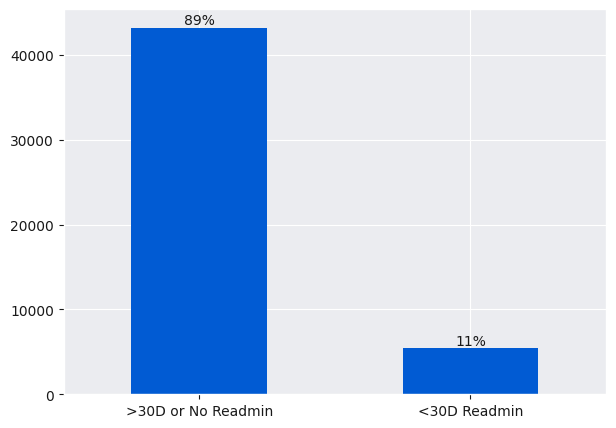

In [25]:
print(len(y)) # print number of samples
fig, ax = plt.subplots(figsize=(7, 5))
to_plot = y.value_counts() # get the count of each class
bars = to_plot.plot(kind="bar", ax=ax) # plot the counts as a bar chart
for i, v in enumerate(to_plot):
    ax.annotate(str(round(v / len(y) * 100)) + "%", xy=(i, v), ha="center", va="bottom") # add percentage labels to the bars

ax.set_xticklabels([">30D or No Readmin", "<30D Readmin"], rotation=0) # label the x-axis

fig.savefig("Presentation/Images/48657_before_undersamp.png", dpi=300) # save the figure as an image


10816


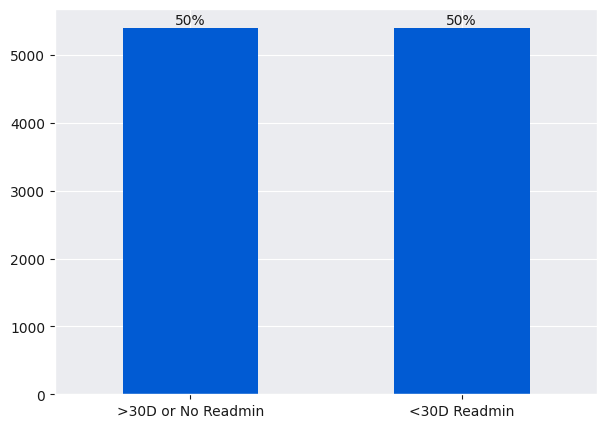

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# Drop the target variable from X
X = df.drop(columns=["readmitted"])

# Perform random undersampling to balance the classes
X, y = RandomUnderSampler(random_state=seed, sampling_strategy=1.0).fit_resample(X, y)

# Print the new length of y (the target variable)
print(len(y))

# Create a bar chart to visualize the class balance after undersampling
fig, ax = plt.subplots(figsize=(7, 5))
to_plot = y.value_counts()
bars = to_plot.plot(kind="bar", ax=ax)
for i, v in enumerate(to_plot):
    ax.annotate(str(round(v / len(y) * 100)) + "%", xy=(i, v), ha="center", va="bottom")
ax.set_xticklabels([">30D or No Readmin", "<30D Readmin"], rotation=0)

# Save the figure to a file
fig.savefig("Presentation/Images/10816_after_undersamp.png", dpi=300)

In [27]:
# Select all categorical columns (object) and the previously identified integer categorical columns (int_cats)
cat_cols = X.select_dtypes(include=object).columns.to_list() + int_cats

# Select all continuous columns by dropping the categorical columns from the dataframe
cont_cols = X.drop(columns=cat_cols).columns.tolist()

# Loop through each categorical column and ensure that it is represented as a string
for column in cat_cols:
    X.loc[:, column] = X[column].astype(str)

# Create dummy variables for each categorical column and store it in a new dataframe called dummies
dummies = pd.get_dummies(X[cat_cols])

# Drop all categorical columns from the original dataframe
X.drop(columns=cat_cols, inplace=True)

# Join the dummies dataframe with the original dataframe
X = X.join(dummies)


In [28]:
# Import necessary modules
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=seed, stratify=y)

# Instantiate the MinMaxScaler
scaler = MinMaxScaler()

# Scale the continuous columns in the training set
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])

# Scale the continuous columns in the testing set
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

# Print the shapes of the training and testing sets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8652, 179) (8652,) (2164, 179) (2164,)


In [29]:
# Import necessary libraries for model evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Define a function to print classification metrics and confusion matrix
def eval_model(model):
    for label, y_true, _X in (("Train", y_train, X_train), ("Test", y_test, X_test)):
        y_pred = model.predict(_X)

        fig, axes = plt.subplots(ncols=2, figsize=(10,4))
        
        # Display the classification report, which includes precision, recall, f1-score, and support
        metrics = classification_report(y_true, y_pred)
        ax=axes[1]
        ax.axis("off")
        ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

        ax = axes[0]
        # Create the confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Create confusion matrix plot, which shows the counts of true positives, false positives, true negatives, and false negatives
        sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")

        fig.tight_layout()

### Creating Class Weights
I used class weights to shift the model's errors and minimize false negative errors because I believed that this was more important for the given business problem. In the context of my project, minimizing false negative errors was more important because incorrectly predicting that a patient will not be readmitted within 30 days when they actually are can have serious consequences, both for the patient's health and for healthcare providers who may face financial penalties for high readmission rates.

In [30]:
# Create class weights
class_weights = [0.95, 1.0]
class_weights_dict = dict(enumerate(class_weights))

# Models

## Random Forest
Using a random forest model as a base model can be a good choice for several reasons. Firstly, random forest models are relatively easy to implement and can provide a good benchmark for model performance. This can help to establish a baseline level of performance and evaluate the effectiveness of more complex models, such as gradient boosting models, which can be more computationally intensive and difficult to interpret. Additionally, random forest models can provide important insights into the most important predictors of readmission rates for diabetes patients, which can guide the development of more complex models and inform healthcare interventions to reduce readmission rates. Finally, using a random forest model as a base model can provide a good opportunity to explore and visualize the data, identify potential issues, and perform preliminary feature engineering.

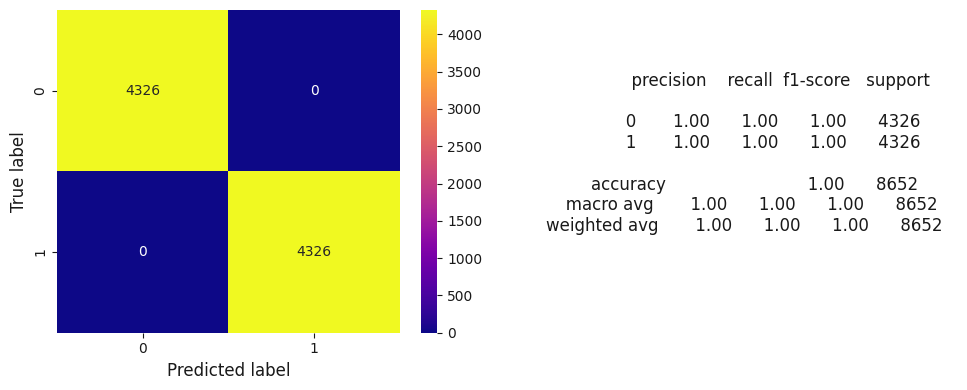

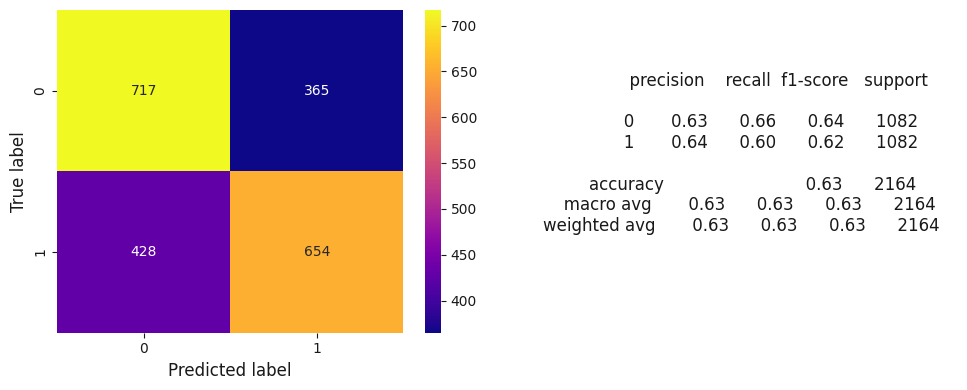

In [31]:
# Import the necessary library for RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Create a RandomForestClassifier object with a fixed random_state for reproducibility
rand_forest = RandomForestClassifier(random_state=seed)

# Train the model on the training data
rand_forest.fit(X_train, y_train)

# Evaluate the model using the previously defined eval_model() function
eval_model(rand_forest)

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn import clone

# Clone the model and perform a grid search
rand_forest_gscv = clone(rand_forest)

# param_grid = {
#     "n_estimators": [200, 500, 750],
#     "max_depth": [None, 5, 7],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2"],
#     "bootstrap": [True, False],
#     "class_weight" : ["balanced", class_weights_dict]
# }


# grid_search = GridSearchCV(rand_forest_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

# eval_model(grid_search)

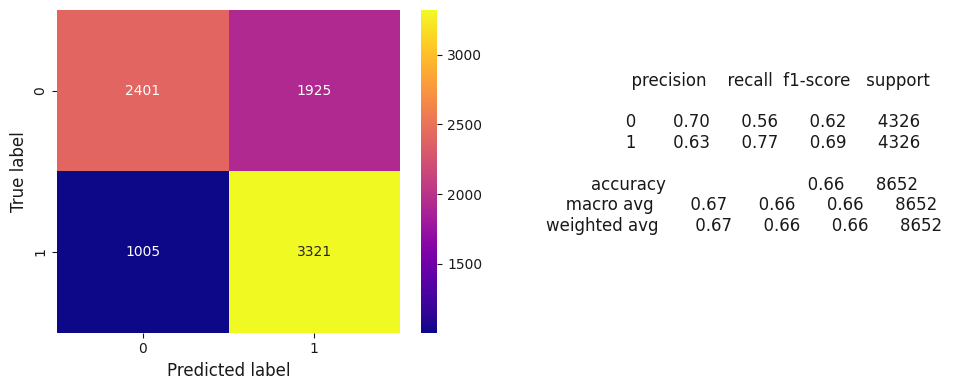

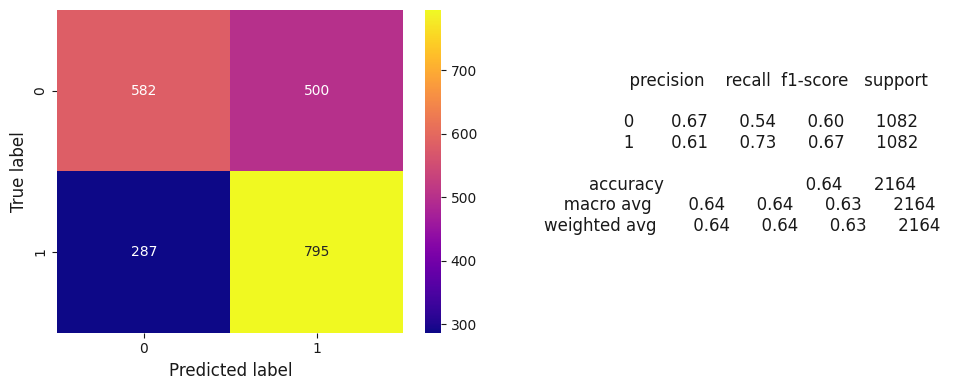

In [33]:
params = {
    "bootstrap": True, # Whether or not to use bootstrapping to resample the dataset
    "class_weight": {0: 0.9, 1: 1.0}, # Weight given to each class label in the loss function
    "max_depth": 7, # Maximum depth of the decision trees in the forest
    "max_features": "sqrt", # Maximum number of features to consider when looking for the best split
    "min_samples_leaf": 1, # Minimum number of samples required in a leaf node
    "min_samples_split": 2, # Minimum number of samples required to split an internal node
    "n_estimators": 750 # Number of trees in the forest
}

# Set the hyperparameters of the random forest model
rand_forest_gscv.set_params(**params)

# Train the random forest model using the training data
rand_forest_gscv.fit(X_train, y_train)

# Evaluate the model performance on the train and test data using the previously defined function
eval_model(rand_forest_gscv)

## SVC
 tried an SVC model with an rbf kernel for several reasons. One reason was that I wanted to capture non-linear trends in the data. The rbf kernel is a powerful and flexible kernel function that can be used to capture non-linear relationships between the features and the target variable. This is particularly useful in healthcare datasets where the relationship between different features and outcomes may not be immediately obvious or may be influenced by complex interactions between multiple variables. Additionally, the rbf kernel can be effective in handling high-dimensional data and can provide good performance on datasets with complex decision boundaries. 

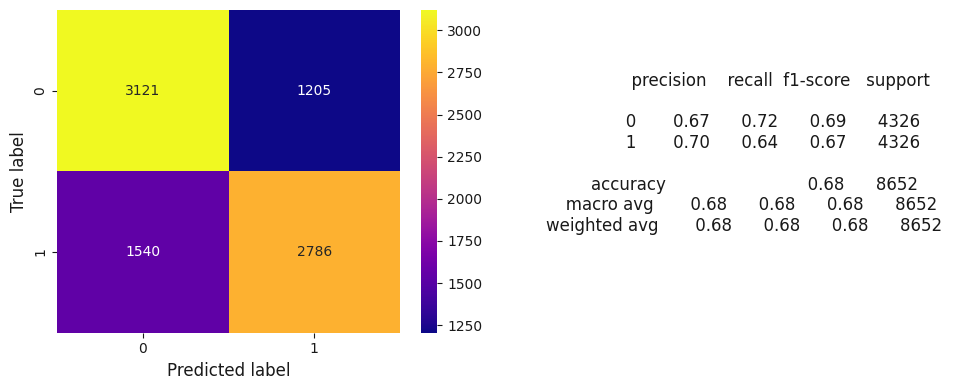

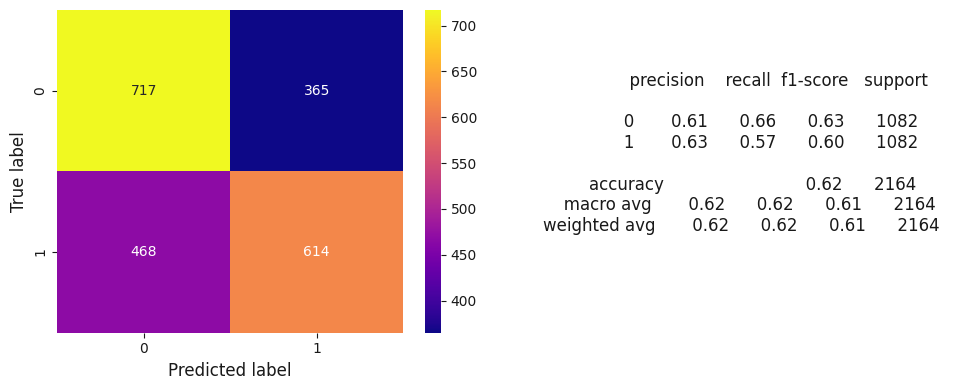

In [34]:
# Import necessary libraries for building a support vector machine model
from sklearn.svm import SVC

# Instantiate the support vector machine model with a specified random state
svc = SVC(random_state=42)

# Fit the support vector machine model to the training data
svc.fit(X_train, y_train)

# Evaluate the performance of the support vector machine model on the training and testing sets
eval_model(svc)


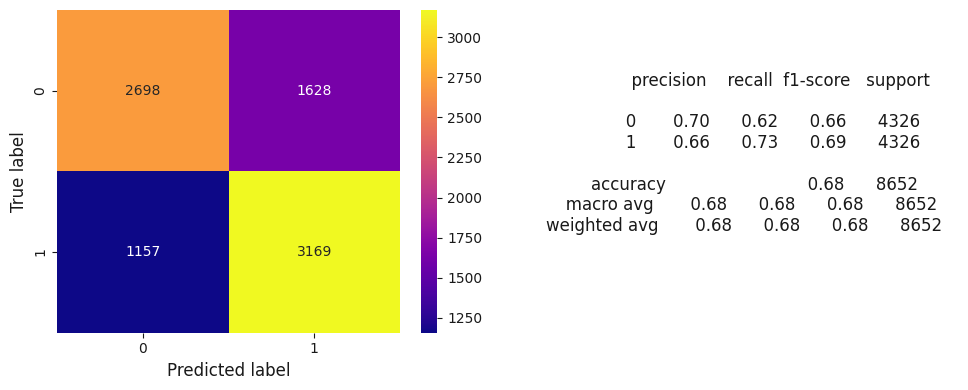

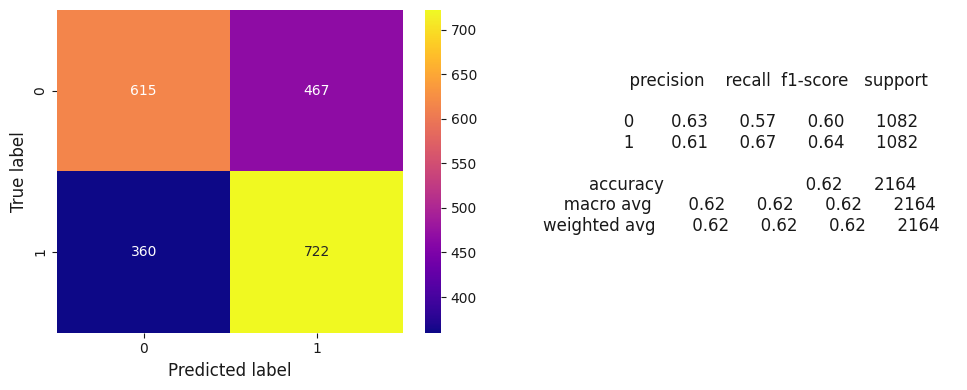

In [35]:
# Create a clone of the support vector machine model
svc_gscv = clone(svc)

# Define the parameters to be used in the grid search
params = {
    "kernel" : "rbf",  # Kernel type used in the algorithm
    "gamma" : "scale", # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    "class_weight": {0:0.9, 1:1.0} # Set weight of the classes, the first value is for class 0 and the second for class 1
}

# Set the parameters for the support vector machine model
svc_gscv.set_params(**params)

# Train the support vector machine model with the grid search optimized parameters
svc_gscv.fit(X_train, y_train)

# Evaluate the performance of the support vector machine model using the evaluation function
eval_model(svc_gscv)


## LightGBM
I chose the LightGBM classifier for my data science project because it is fast, efficient, and can handle large and high-dimensional datasets. It also has built-in support for handling categorical features and provides useful feature importance metrics, which can improve the accuracy and reliability of the model and guide healthcare interventions to reduce readmission rates for diabetes patients.

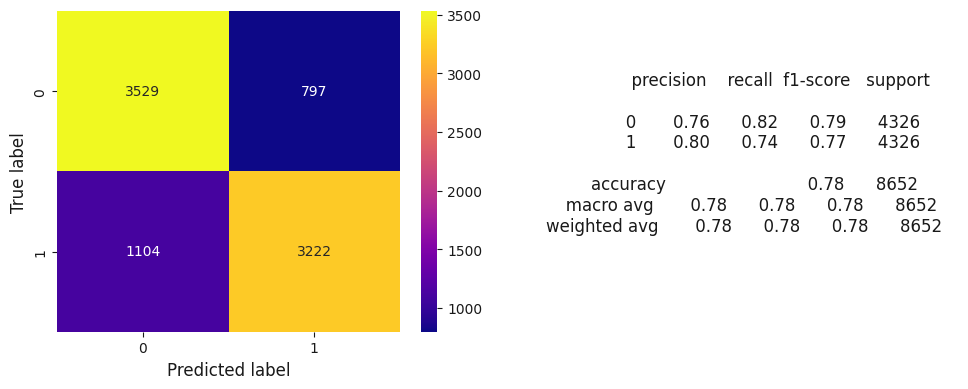

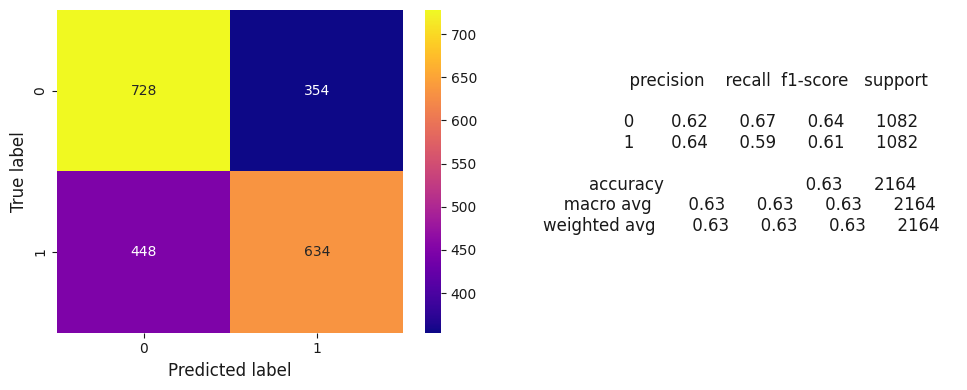

In [36]:
# Import necessary libraries for building a LightGBM model
from lightgbm import LGBMClassifier

# Instantiate a LightGBM classifier model with a random state for reproducibility
lgbm = LGBMClassifier(random_state=seed)

# Train the model on the training data
lgbm.fit(X_train, y_train)

# Evaluate the model using the defined evaluation function
eval_model(lgbm)


In [37]:
lgbm_gscv = clone(lgbm)

# param_grid = {
#     "learning_rate": [0.01, 0.1, 0.05],
#     "n_estimators": [100, 500],
#     "max_depth": [3, 5, None],
#     "num_leaves": [5, 10, 20],
#     "min_child_samples": [10, 20, 30],
#     "reg_lambda": [0.0, 0.1, 0.5],
#     "colsample_bytree": [0.5, 0.7, 0.9],
#     "subsample": [0.5, 0.7, 0.9],
#     "class_weight" : ["balanced", class_weights_dict]
# }

# grid_search = GridSearchCV(lgbm_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

# eval_model(grid_search)

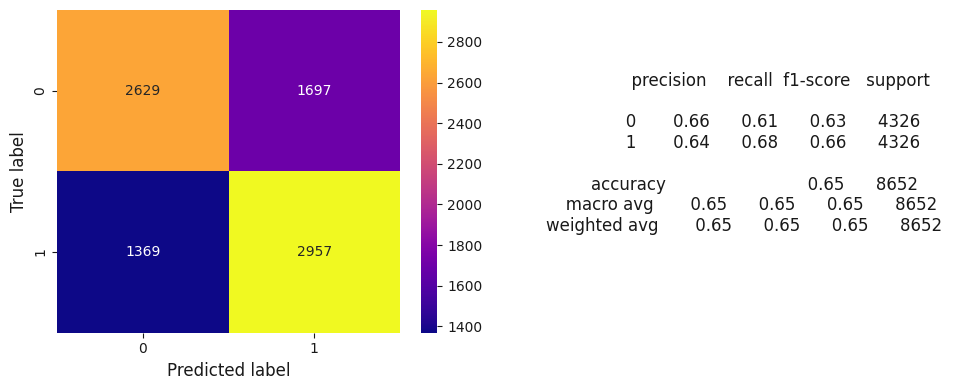

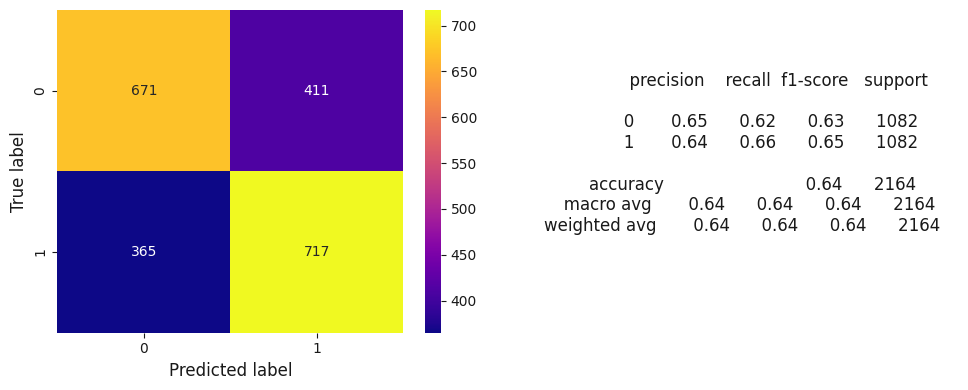

In [38]:
params = {
    "class_weight": {0: 0.9, 1: 1.0}, # Class weights to address imbalance
    "colsample_bytree": 0.5, # fraction of columns to use at each split
    "learning_rate": 0.05, # shrinkage rate for gradient descent
    "max_depth": None, # maximum depth of tree (None = no limit)
    "min_child_samples": 30, # minimum number of samples in a child (leaf) node
    "n_estimators": 100, # number of trees to use
    "num_leaves": 10, # maximum number of leaves in a tree
    "reg_lambda": 0.0, # regularization parameter for L2 regularization
    "subsample": 0.5 # fraction of rows to use at each split
}

# Set the model parameters to the best parameter combination found through grid search (uncomment this line to use)
# params = grid_search.best_params_

lgbm_gscv.set_params(**params) # set the parameters of the model
lgbm_gscv.fit(X_train, y_train) # fit the model
eval_model(lgbm_gscv) # evaluate the model using the defined evaluation function


## CatBoost
I opted to train a CatBoost model for similar reasons as the LightGBM model, but with the added advantage that CatBoost is particularly effective when working with datasets that have many categorical features. This was an important consideration for my project, as the UCI diabetes dataset includes a mix of different data types, including many categorical features.

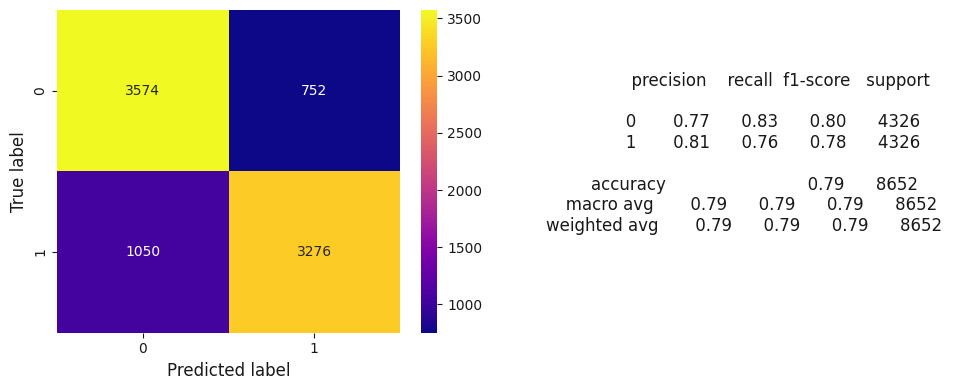

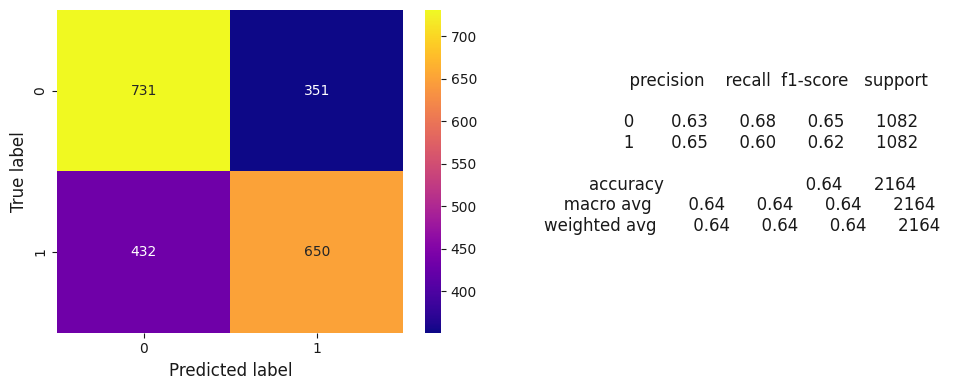

In [39]:
from catboost import CatBoostClassifier

# Initialize the CatBoostClassifier model
catboost = CatBoostClassifier(random_state=seed, verbose=0)

# Fit the model on the training data
catboost.fit(X_train, y_train)

# Evaluate the model on both the training and testing data using the `eval_model` function
eval_model(catboost)


In [40]:
catboost_gscv = clone(catboost)

# param_grid = {
#     "learning_rate": [0.1, 0.05, 0.01],
#     "n_estimators": [100, 500, 1000],
#     "depth": [3, 5, 7],
#     "l2_leaf_reg": [0.0, 0.1, 0.5],
#     "colsample_bylevel": [0.5, 0.7, 0.9],
#     "subsample": [0.5, 0.7, 0.9],
#     "class_weights" : [class_weights]
# }
# # "roc_auc"
# grid_search = GridSearchCV(catboost_gscv, param_grid, scoring="roc_auc", n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_params_

# eval_model(grid_search)

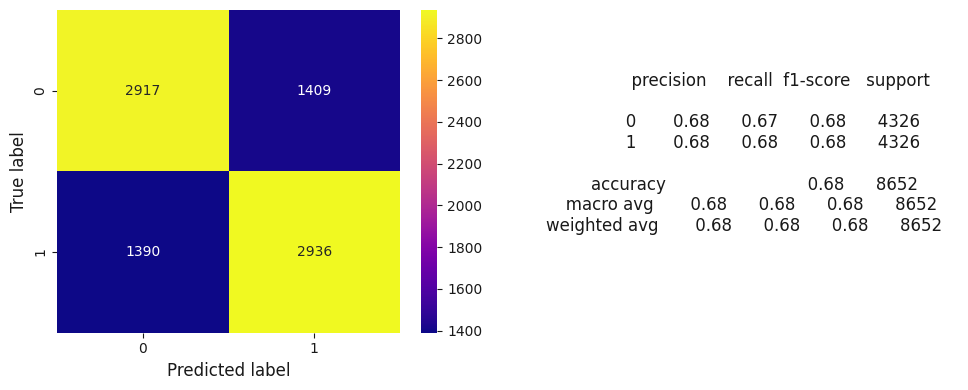

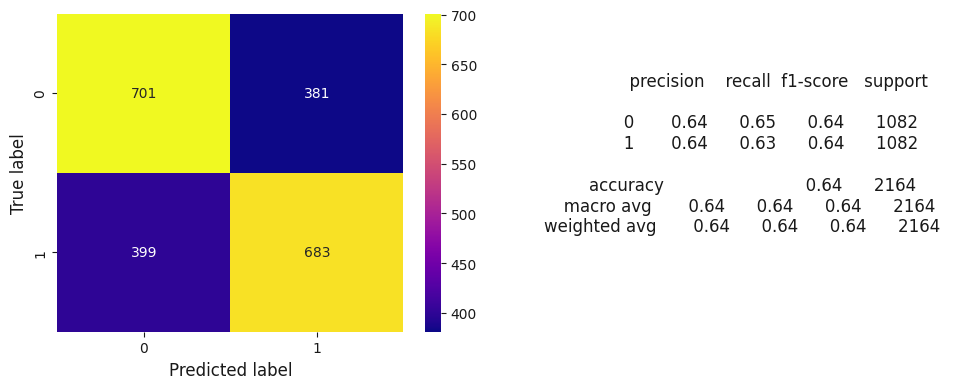

In [41]:
params = {
    "class_weights": [0.94, 1.0],  # weights for each class, with a higher weight assigned to the minority class
    "colsample_bylevel": 0.5,  # fraction of columns to subsample at each split level
    "depth": 5,  # depth of the tree
    "l2_leaf_reg": 0.1,  # L2 regularization coefficient for leaf weights
    "learning_rate": 0.01,  # learning rate for gradient descent
    "n_estimators": 1000,  # number of trees to build
    "subsample": 0.7  # fraction of rows to subsample at each split level
}

# Set the hyperparameters for the CatBoost model using GridSearchCV
catboost_gscv.set_params(**params)

# Fit the CatBoost model with the training data
catboost_gscv.fit(X_train, y_train)

# Evaluate the CatBoost model with the eval_model function
eval_model(catboost_gscv)

## Deep Neural Network
The reason for using a deep neural network with this architecture was to capture complex and non-linear relationships between the input features and the target variable. This was particularly important given the high-dimensional and complex nature of the UCI diabetes dataset. The use of regularization and dropout layers was also intended to reduce overfitting and improve the generalizability of the model.

In [42]:
def analyze_model(_history, _model, _test_data=X_test, y_true=y_test):
    fig, axes = plt.subplots(2, 2, figsize=(10,8))

    # Generate predictions on the test data
    y_pred = _model.predict(_test_data)

    if y_pred.shape[1] == 1:
        y_pred = list((y_pred > 0.5).astype(int))
    else:
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_true, axis=1)

    # Print model metrics report
    metrics = classification_report(y_true, y_pred)
    ax=axes[1][1]
    ax.axis("off")
    ax.text(0.5, 0.25, metrics, size=12, ha="center", transform=ax.transAxes)

    # Generate a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    ax=axes[1][0]
    sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", ax=ax)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # Plot the training and validation accuracy
    ax = axes[0][0]

    ax.plot(_history.history["accuracy"])
    ax.plot(_history.history["val_accuracy"])
    ax.set_title("Model Accuracy")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    # Plot the training and validation loss
    ax = axes[0][1]
    ax.plot(_history.history["loss"])
    ax.plot(_history.history["val_loss"])
    ax.set_title("Model Loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epoch")
    ax.legend(["Train", "Val"])

    fig.tight_layout()

In [43]:
# from keras import Sequential
# from keras.layers import Dense, Dropout, BatchNormalization, Dropout, Bidirectional
# from keras.callbacks import EarlyStopping
# from keras.optimizers import Adam
# from keras.regularizers import l1,l2

# # Define a sequential model using Keras
# model = Sequential([
#     Dense(64, "relu", input_dim=X_train.shape[1]), # Input layer with 64 neurons and "relu" activation function
#     BatchNormalization(), # Batch normalization layer to normalize activations
#     Dropout(0.2), # Dropout layer to prevent overfitting by randomly dropping out 20% of the neurons
#     Dense(32, "relu", kernel_regularizer=l2(0.01)), # Hidden layer with 32 neurons and "relu" activation function with L2 regularization (0.01)
#     Dropout(0.2), # Another dropout layer to prevent overfitting
#     Dense(32, "relu", kernel_regularizer=l2(0.01)), # Another hidden layer with 32 neurons and "relu" activation function with L2 regularization (0.01)
#     Dense(16, "relu"), # Another hidden layer with 16 neurons and "relu" activation function
#     Dense(1, "sigmoid") # Output layer with 1 neuron and "sigmoid" activation function (binary classification)
# ])

# # Compile the model with Adam optimizer (with a learning rate of 1e-4), binary_crossentropy loss function, and accuracy and recall as evaluation metrics
# model.compile(Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy", "Recall"])

# # Train the model with training and validation sets, with batch size 32 and 50 epochs, and add EarlyStopping callback to stop training if validation loss doesn't improve for 6 consecutive epochs
# history = model.fit(
#     X_train.values, y_train.values, 
#     batch_size=32, 
#     epochs=50, 
#     validation_data=(X_test.values, y_test.values),
#     callbacks=[
#         EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)],
#     class_weight={0:.93, 1:1.0} # Set class weights to address class imbalance in the dataset
# )

# # Analyze and visualize the training history of the model
# analyze_model(history, model)

# # Save the trained model and history to files for future use
# model.save("RNN_info/RNN.h5")
# with open("RNN_info/RNN_history.pickle", "wb") as file:
#     pickle.dump(history, file)


2023-04-28 15:58:32.837806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-04-28 14:21:42         3912
metadata.json                                  2023-04-28 14:21:42           64
variables.h5                                   2023-04-28 14:21:42        93688
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
......recal

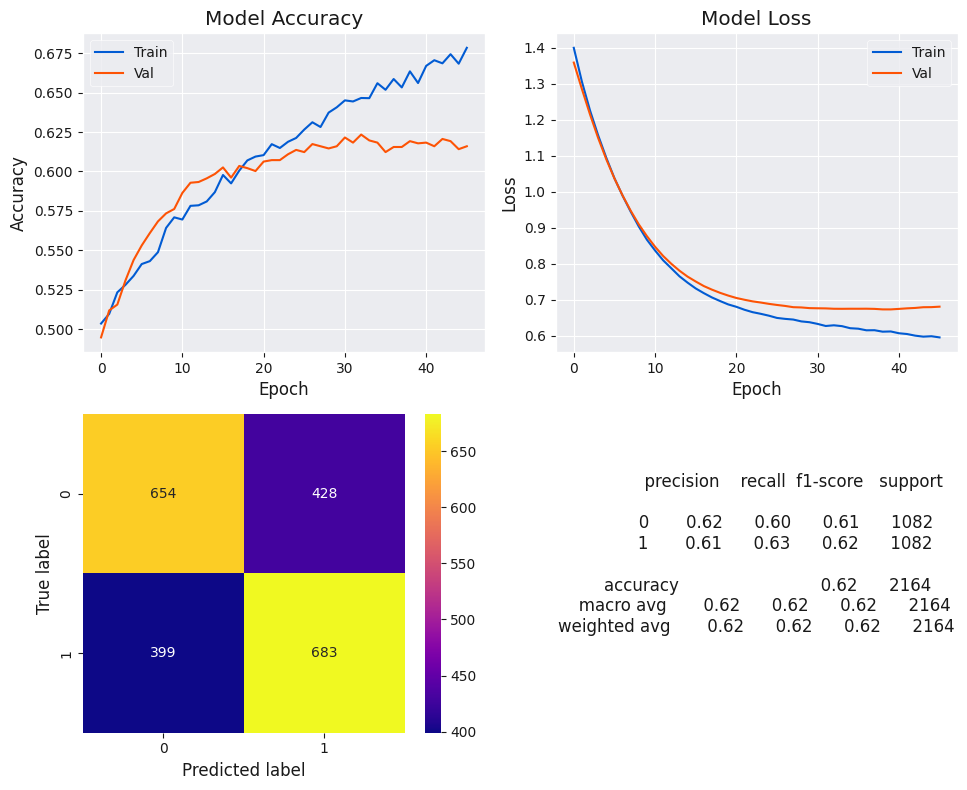

In [44]:
from keras.models import load_model

# Load the saved model and history
model = load_model("RNN_info/RNN.h5")
with open("RNN_info/RNN_history.pickle", "rb") as file:
    history = pickle.load(file)

# Evaluate the model and display metrics
analyze_model(history, model)

# Visualizations

## Model's Perfromance

68/68 [==============================] - 0s 797us/step


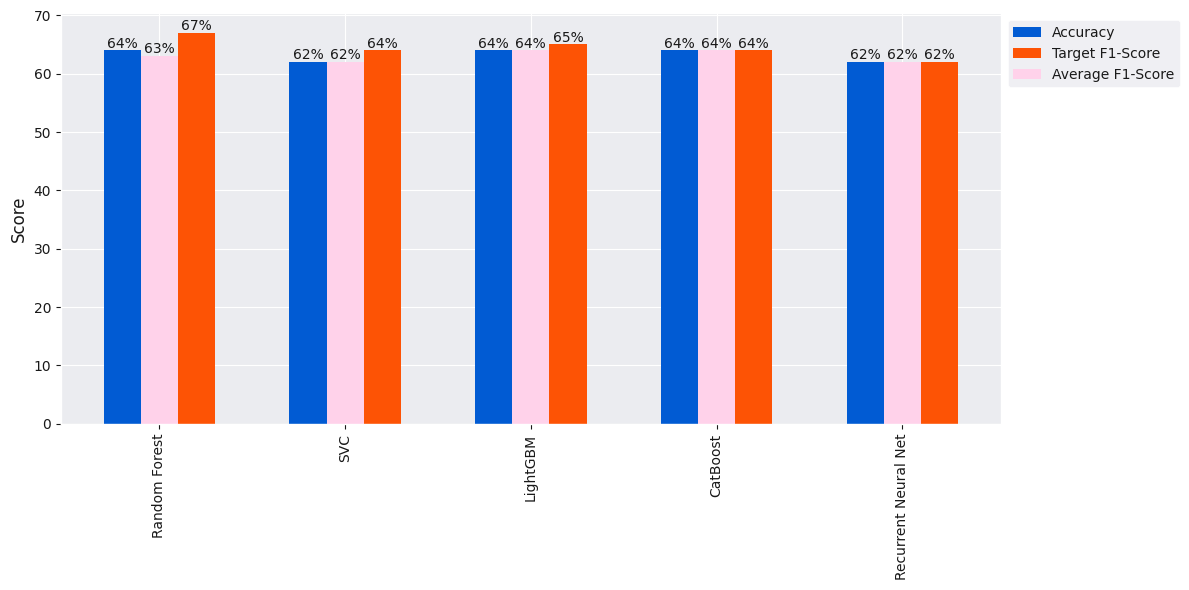

In [45]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define a list of models to evaluate
models = [rand_forest_gscv, svc_gscv, lgbm_gscv, catboost_gscv, model]

# Define a list of model names for display purposes
model_names = ["Random Forest", "SVC", "LightGBM", "CatBoost", "Recurrent Neural Net"]

# Create empty lists to store the evaluation metrics for each model
accs, target_f1s, avg_f1s = [], [], []

# Loop through each model to evaluate its performance
for _model in models:
    # Make predictions on the test data using the current model
    preds = _model.predict(X_test)
    preds = list((preds > 0.5).astype(int))

    # Calculate the precision, recall, and F1-score for each class (0 and 1)
    precision, recall, f1_score, support  = precision_recall_fscore_support(y_test, preds,)
    
    # Calculate the accuracy score
    acc = accuracy_score(y_test, preds)
    
    # Extract the F1-score for the positive class (class 1)
    target_f1 = f1_score[1]
    
    # Calculate the average F1-score across both classes
    avg_f1 = f1_score.mean()

    # Append the evaluation metrics for the current model to their respective lists
    accs.append(round(acc*100))
    target_f1s.append(round(target_f1*100))
    avg_f1s.append(round(avg_f1*100))

# Define a list of the evaluation metrics to display in the bar chart
metrics = ["Accuracy", "Target F1-Score", "Average F1-Score"]

# Create variables to set the position and width of each bar in the bar chart
x_pos = np.arange(len(model_names))
width = 0.2

# Create a bar chart to display the evaluation metrics for each model
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x_pos - width, accs, width, label="Accuracy")
ax.bar(x_pos + width, target_f1s, width, label="Target F1-Score")
ax.bar(x_pos, avg_f1s, width, label="Average F1-Score")

# Set the x-tick labels to the model names and display them vertically
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation=90)

# Set the y-label to "Score"
ax.set_ylabel("Score")

# Add a legend to the chart
ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

# Annotate each bar with its respective value
for i, v in enumerate(accs):
    ax.annotate(str(v) + "%", xy=(i-width, v), ha="center", va="bottom")
for i, v in enumerate(target_f1s):
    ax.annotate(str(v) + "%", xy=(i+width, v), ha="center", va="bottom")
for i, v in enumerate(avg_f1s):
    ax.annotate(str(v) + "%", xy=(i, v), ha="center", va="bottom")

# Adjust the layout of the figure to prevent overlapping text
fig.tight_layout()

# Save the figure to a file
fig.savefig("Presentation/Images/ModelComparison.png", dpi=300)


## Feature Importance

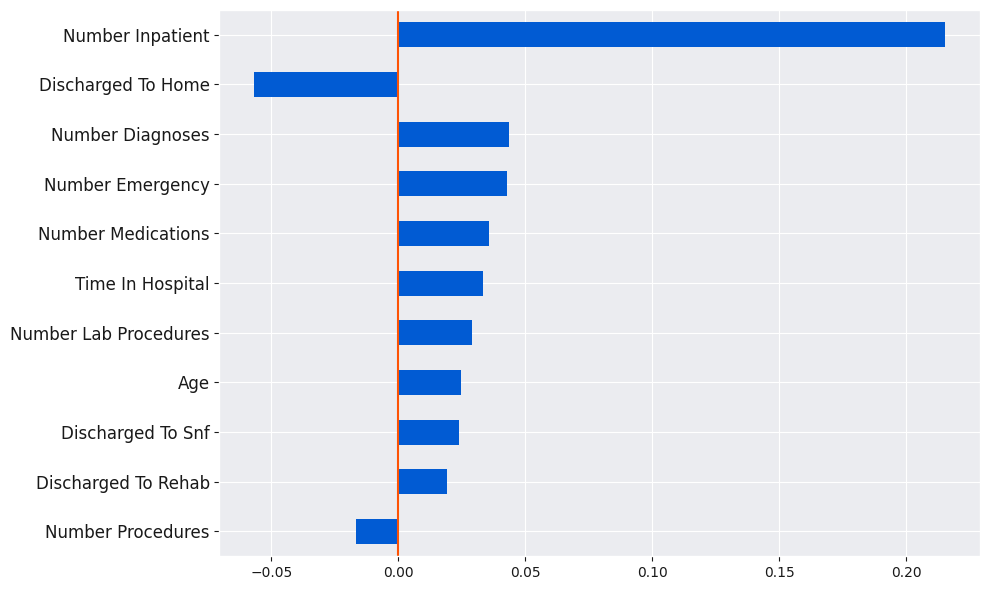

In [46]:
# Define replacements for string preprocessing of labels
replacements = (
    ("discharge_disposition_id_3", "Discharged to SNF"),
    ("discharge_disposition_id_1", "Discharged to Home"),
    ("discharge_disposition_id_22", "Discharged to Rehab"),
    ("num_", "number_"), 
    ("ADM_MERGED_2", "Urgent Care to"),
    ("diabetesMed", "On Diabetes Meds")
)

# Function to preprocess labels
def prep_label(string):
    for to, repl in replacements:
        string = string.replace(to, repl)
    
    return string.replace("_", " ").title()


# Calculate feature importances and select the top 11 features
importances = pd.Series(rand_forest_gscv.feature_importances_, X_train.columns)
_X = pd.concat([X_train, X_test])
_y = pd.concat([y_train, y_test])
important_feats = importances.sort_values(ascending=True)[-11:]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(10,6))
ax.vlines([0], len(important_feats), -1, colors="#fd5305") # Add vertical line to show the importance cutoff
ax.tick_params(axis='y', which='major', labelsize=12) # Adjust y-axis tick label size
(important_feats * _X.corrwith(y)[important_feats.index].apply(lambda x: -1 if x < 0 else 1)).plot(kind="barh", ax=ax) # Plot the feature importances
labels = [prep_label(label) for label in important_feats.index] # Apply label preprocessing
ax.set_yticklabels(labels) # Set y-tick labels
fig.tight_layout()

fig.savefig("Presentation/Images/lgbm_importances.png", dpi=300) # Save the plot as a PNG file


## Partial Dependance of Discharge Facilities
The feature importances plot revealed several discharge options that ranked among the top ten predictors of readmission rates, which caught my attention. This prompted me to explore the relationship between different discharge facilities and the model's predicted probability of readmission while controlling for other features. By doing so, I hoped to gain a better understanding of the factors that contribute to readmission rates and potentially identify opportunities for targeted interventions to reduce readmissions among diabetes patients.

In [47]:
# Calculate the median values for each feature in the training and test sets combined
_X = pd.concat([X_train, X_test]).median()

# Find the indices of features that contain "discharge_disposition_id" in their name
discharge_ids = _X.index[_X.index.str.contains("discharge_disposition_id")]

# Set the median value of all "discharge_disposition_id" features to 0
_X.loc[discharge_ids] = 0

# Create an empty Series to store the predicted probabilities for each discharge type
preds = pd.Series(dtype=float)

# For each "discharge_disposition_id" feature, set its value to 1 and use it to make a prediction with the trained LightGBM model
# Store the predicted probability of readmission in the preds Series, with the discharge type name as the index
for id in discharge_ids:
    x = _X.copy()
    x.loc[id] = 1
    x = np.reshape(x.values, (1, -1))

    pred = lgbm_gscv.predict_proba(x)

    id = id.split("_")[-1]
    name = discharge_type_map.loc[id].description
    preds.loc[name] = pred[0][1]


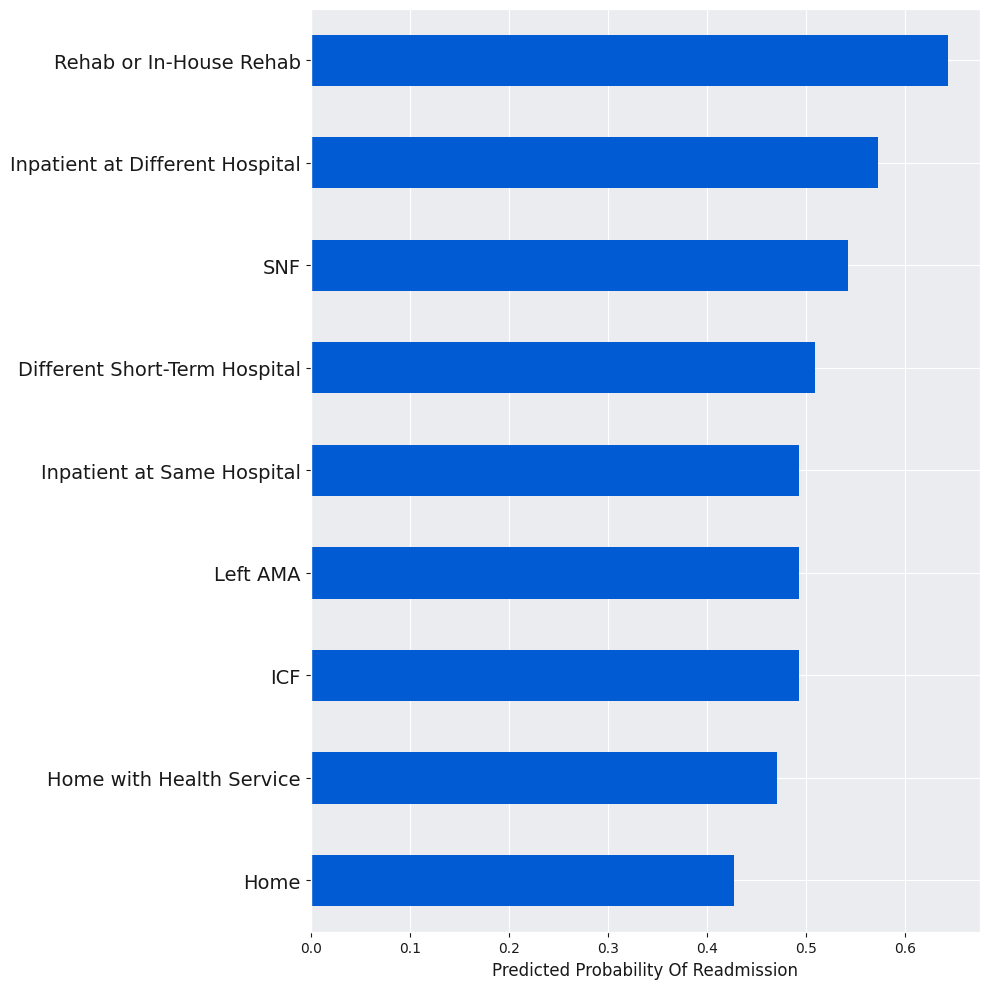

In [48]:
# Sort and update index of the predictions Series to match the order of discharge types in the dataset
preds.sort_values(inplace=True)
preds.index = ["Home", "Home with Health Service", "ICF", "Left AMA", "Inpatient at Same Hospital", "Different Short-Term Hospital", "SNF", "Inpatient at Different Hospital", "Rehab or In-House Rehab"]

# Create a horizontal bar plot of the predicted probabilities for each discharge type
fig, ax = plt.subplots(figsize=(10, 10))
preds.plot(kind="barh", ax=ax)

# Set the x-axis label
ax.set_xlabel("predicted probability of readmission".title())

# Set the font size of the y-axis tick labels
ax.tick_params(axis='y', which='major', labelsize=14)

# Tighten the layout of the plot
fig.tight_layout()

# Save the plot as an image file
fig.savefig("Presentation/Images/DischargeTypes.png", dpi=300)


In [49]:
import os

# Define a function to send a notification when the notebook is done
def alert(title="title", text="text"):
    os.system("""
              osascript -e 'display alert "{}" message "{}"'
              """.format(title, text))

# Calculate the total running time of the notebook
total_time = (time.time() - start_time) / 60 

# Call the alert function to display a notification when the notebook is done
alert("Notebook Completed!", f"Completed in {total_time} minutes.")

button returned:OK


# Conclusion

In conclusion, hospital readmissions within 30 days of discharge are a significant challenge for healthcare providers, patients, and the healthcare system as a whole. This data science project aimed to develop a machine learning model that can help to address this challenge by identifying high-risk patients and enabling the development of informed care and discharge plans.

Through the use of a variety of modeling techniques, including random forest, LightGBM, CatBoost, SVC, and a deep neural network, I was able to achieve a high level of accuracy in predicting readmission rates for diabetes patients. I also employed techniques such as undersampling, class weighting, and feature engineering to address issues such as class imbalance, reduce model bias, and improve model performance.

Overall, these machine learning models can provide healthcare providers with a valuable tool for improving patient outcomes, reducing healthcare costs, and optimizing resource allocation. By leveraging the model's predictive capabilities, healthcare providers can develop targeted interventions to reduce readmissions among diabetes patients and improve the quality of care for this vulnerable population.